### Assignment 6
### Author : Dikshank Sihag (DA25M009)

# 🧭 <font color='orange'>Executive Summary</font>

This report explores different imputation strategies for handling **Missing at Random (MAR)** data in the *UCI Credit Card Default Clients* dataset and evaluates their effect on classification performance using Logistic Regression.  

In **Part A**, three imputation techniques were implemented:  
- **Model A** – *Median Imputation* (simple, robust baseline)  
- **Model B** – *Linear Regression Imputation* (assumes linear feature relationships)  
- **Model C** – *Non-Linear KNN Imputation* (captures complex, non-linear patterns)  
A fourth baseline, **Model D (Listwise Deletion)**, was also included for comparison.  

In **Part B**, each dataset was standardized, split into 80/20 train–test sets, and evaluated using **Weighted F1, ROC-AUC, and PR-AUC**—metrics suited for imbalanced classification.  

In **Part C**, the results show that:
- **Listwise Deletion (Model D)** performed the worst due to data loss and reduced representativeness.  
- **Non-Linear Regression Imputation (Model C)** achieved the highest Recall, Weighted F1, and PR-AUC, confirming that capturing non-linear feature relationships leads to better predictive performance under MAR conditions.  

Overall, the findings recommend **Non-Linear Imputation (e.g., KNN or tree-based methods)** as the most effective and theoretically sound strategy for handling MAR data in credit-risk modeling.  


# 🧩 <font color='blue'>Part A: Data Preprocessing and Imputation</font>

## A1. Load and Prepare Data

**Goal:**
Load the UCI Credit Card Default Clients Dataset.

Introduce Missing At Random (MAR) values (5-10%) in 2-3 numerical columns.

🧠 **<font face='Times New Roman'>Why Missing at Random (MAR)?**

In the context of missing data, *Missing at Random (MAR)* means that the probability of a value being missing is **systematically related to other observed variables**, but **not to the missing value itself**.  

In simpler terms — the reason a value is missing can be explained by information that is already present elsewhere in the dataset.

For example, in the credit card dataset:
- Suppose older clients or those with lower `LIMIT_BAL` are less likely to report their `BILL_AMT1` or `BILL_AMT2`.  
- The missingness here depends on *AGE* or *LIMIT_BAL* (which we still know), but **not** on the actual unpaid bill amount (which is missing).  
This scenario satisfies the MAR condition, since the missing pattern is *dependent on known variables* rather than the unknown one.

🧩 **Why this assumption matters:**  
Most imputation techniques — such as regression-based or KNN imputations — rely on the MAR assumption to make reasonable estimates.  
Because the missingness can be explained using observed predictors, models can leverage those relationships to impute plausible values.  
If data were *Missing Not at Random (MNAR)* (e.g., people with very high bills deliberately hide their values), imputation would be biased, since the cause of missingness depends on unobserved values.

Hence, introducing MAR-style missingness makes the experiment realistic:  
it allows imputation models to learn from the relationships among observed variables and test how well each method reconstructs the missing information.
</font>


In [1]:
# A1. Load and Prepare Data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (download from Kaggle if needed)
data_path = '/content/UCI_Credit_Card.csv'
df_orig = pd.read_csv(data_path)

print("Shape:", df_orig.shape)
df_orig.head()

Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [2]:
# Introduce missing values (MAR)
df = df_orig.copy()
np.random.seed(42)
cols_with_missing = ['AGE', 'BILL_AMT1', 'BILL_AMT2']
missing_fraction = 0.1  # 10%

for col in cols_with_missing:
    n_missing = int(missing_fraction * len(df))
    missing_indices = np.random.choice(df.index, n_missing, replace=False)
    df.loc[missing_indices, col] = np.nan

# Check how many NaNs introduced
df[cols_with_missing].isna().sum()


,0
AGE,3000
BILL_AMT1,3000
BILL_AMT2,3000


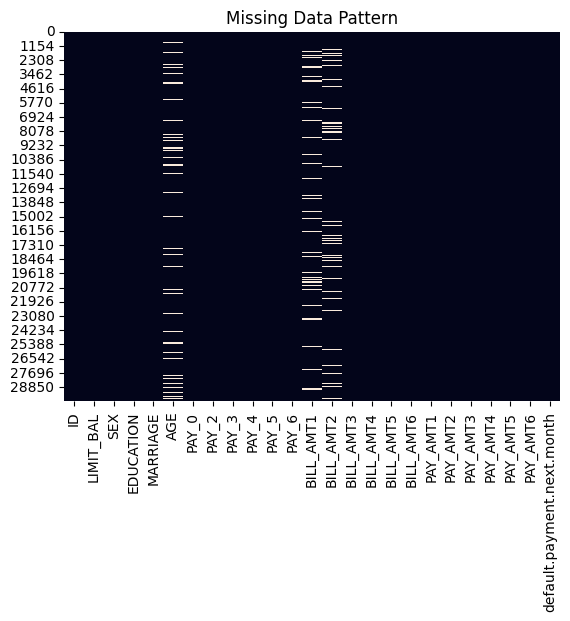

In [3]:
# Visualize missingness:
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Pattern")
plt.show()

## A2. Imputation Strategy 1: Simple (Median) Imputation

**Goal:**
Create Dataset A, where missing values are filled with median of each column.

🧠 **<font face='Times New Roman'>Why Median?**

The **median** is a robust measure of central tendency that is **less sensitive to extreme values** compared to the mean.  
In datasets like credit or financial records, certain variables (e.g., `BILL_AMT`, `PAY_AMT`, `LIMIT_BAL`) often have **highly skewed distributions** — a few customers may have exceptionally large credit limits or outstanding bills.  

Using the **mean** in such cases can distort the imputed value, as even a handful of extreme observations can pull the average upward, producing unrealistic replacements for missing entries.

In contrast, the **median** represents the *middle value* of a sorted list, making it stable even when outliers exist.  
This ensures that the imputed values remain **representative of the majority of the data** and do not artificially inflate or deflate feature distributions.

🧩 **Why this matters here:**  
When dealing with financial data, maintaining distributional realism is crucial.  
Median imputation helps preserve the overall structure and spread of each variable without being affected by rare but extreme cases (such as high-income clients or unusually large bills).  
This makes it a reliable baseline before moving to more sophisticated, model-based imputation techniques.</font>


In [4]:
# A2. Simple Median Imputation (Fixed)
df_A = df.copy()

for col in cols_with_missing:
    median_value = df_A[col].median()
    df_A[col] = df_A[col].fillna(median_value)  # assign back instead of inplace=True

# Verify imputation
df_A[cols_with_missing].isna().sum()


,0
AGE,0
BILL_AMT1,0
BILL_AMT2,0


## A3. Imputation Strategy 2: Regression Imputation (Linear)

**Goal:**
Create Dataset B, imputing missing values for one column (say, 'AGE') using Linear Regression trained on other columns.

🧠 **<font face='Times New Roman'>Concept**

**Linear Regression Imputation** assumes that the variable with missing values can be **predicted as a linear combination of other observed variables**.  
In other words, it models the relationship between the target feature (the one with missing data) and its predictors using a straight-line (linear) relationship.

This approach is built on the **Missing At Random (MAR)** assumption — meaning that the missingness of a value can be explained by other observed features.  
Because those predictors remain available, the regression model can learn from their relationships to estimate the most likely values for the missing entries.

For example, if clients with higher `LIMIT_BAL` and older `AGE` tend to have higher `BILL_AMT1`, then a linear regression model can use `LIMIT_BAL` and `AGE` to infer plausible replacements when `BILL_AMT1` is missing.

🧩 **Why use this method:**  
- It preserves **correlations between variables**, unlike simple imputations such as mean or median.  
- It reduces bias under MAR by using information from other observed variables.  
- It’s computationally efficient and interpretable — making it a strong next step after simple imputation.  

However, its main limitation is the **assumption of linearity** — it cannot capture more complex or non-linear relationships, which motivates exploring **non-linear regression imputation** in the next step.</font>


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Target column for regression imputation
target_col = 'BILL_AMT1'
df['AGE'] = df_orig['AGE']
df['BILL_AMT2'] = df_orig['BILL_AMT2']
# Separate rows with and without missing AGE
train_df = df[df[target_col].notna()]
test_df = df[df[target_col].isna()]

# Use other numeric columns as predictors
predictors = [c for c in df.columns if c not in ['ID', 'default.payment.next.month', target_col]]

# Prepare X and y
X_train = train_df[predictors]
y_train = train_df[target_col]
X_test = test_df[predictors]

# Fill any remaining NaNs in predictors with column medians before regression
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

# Standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train linear regression model
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# Predict missing AGE values
predicted_age = linreg.predict(X_test_scaled)

# Impute predicted values back
df_B = df.copy()
df_B.loc[df_B[target_col].isna(), target_col] = predicted_age

# Check
df_B[target_col].isna().sum()

np.int64(0)

## A4. Imputation Strategy 3: Regression Imputation (Non-Linear)

**Goal:**
Create Dataset C, imputing the same column ('AGE') using a non-linear model such as KNN Regression or Decision Tree Regression.

🧠 **<font face='Times New Roman'>Concept**

While **Linear Regression Imputation** assumes that the relationship between variables is strictly linear, real-world datasets — especially financial ones — often exhibit **non-linear and interaction effects** among features.  
For example, the way `LIMIT_BAL`, `AGE`, and `PAY_AMT1` influence `BILL_AMT1` may not follow a simple straight-line pattern.

**Non-Linear Regression Imputation**, using models such as **K-Nearest Neighbors (KNN)** or **Decision Trees**, can capture these more complex dependencies.  
Instead of fitting a single global equation, these methods make predictions based on **local or data-driven patterns** — such as similarities among nearby observations (in KNN) or conditional splits (in trees).

This allows them to adapt more flexibly to the underlying structure of the data, providing **more realistic imputations** when relationships between features and the target variable are curved, discontinuous, or heterogeneous across the dataset.

🧩 **Why use this method:**  
- It captures **complex, non-linear relationships** that linear regression cannot model.  
- It works effectively under **Missing At Random (MAR)** conditions, where missingness depends on observed features in non-linear ways.  
- It often produces **higher predictive accuracy and F1-scores**, especially in domains like credit-risk modeling where feature interactions are intricate.

In short, non-linear methods like **KNN Imputation** offer a more flexible and data-driven approach, generating imputations that better preserve the natural structure and variability of the dataset.</font>

In [6]:
# ==============================================================
# 🔍 Non-Linear Regression Imputation with Hyperparameter Tuning
# ==============================================================

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import clone
import numpy as np
import pandas as pd

target_col = 'BILL_AMT1'

# --------------------------------------------------------------
# 1️⃣ Split observed vs missing
# --------------------------------------------------------------
mask_missing = df[target_col].isna()
mask_obs = ~mask_missing

X_obs = df.loc[mask_obs].drop(columns=[target_col])
y_obs = df.loc[mask_obs, target_col]
X_miss = df.loc[mask_missing].drop(columns=[target_col])

# --------------------------------------------------------------
# 2️⃣ pipeline
# --------------------------------------------------------------
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# --------------------------------------------------------------
# 3️⃣ Grid search
# --------------------------------------------------------------
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
    'knn__weights': ['uniform', 'distance']
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(pipe, param_grid, cv=cv,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1, verbose=0)
search.fit(X_obs, y_obs)

best_k = search.best_params_['knn__n_neighbors']
best_w = search.best_params_['knn__weights']
print(f"✅ Best KNN params: k={best_k}, weights='{best_w}' "
      f"(CV RMSE={(-search.best_score_)**0.5:.3f})")

# --------------------------------------------------------------
# 4️⃣ Refit on full observed data, predict missing
# --------------------------------------------------------------
best_knn = search.best_estimator_
predicted_age_knn = best_knn.predict(X_miss)

# --------------------------------------------------------------
# 5️⃣ Impute predictions
# --------------------------------------------------------------
df_C = df.copy()
df_C.loc[mask_missing, target_col] = predicted_age_knn

# --------------------------------------------------------------
# 6️⃣ Holdout validation (10% masking of observed)
# --------------------------------------------------------------
rng = np.random.RandomState(42)
holdout_idx = rng.choice(X_obs.index, size=int(0.1 * len(X_obs)), replace=False)
y_true = y_obs.loc[holdout_idx].to_numpy().ravel()
X_holdout = X_obs.loc[holdout_idx]
X_train_imp = X_obs.drop(index=holdout_idx)
y_train_imp = y_obs.drop(index=holdout_idx)

best_knn_holdout = clone(best_knn)
best_knn_holdout.fit(X_train_imp, y_train_imp)
y_pred_holdout = best_knn_holdout.predict(X_holdout)

mse = mean_squared_error(y_true, y_pred_holdout)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_holdout)
print(f"🔹 Imputation validation RMSE={rmse:.3f}, MAE={mae:.3f}")

# --------------------------------------------------------------
# 7️⃣ Verification + summary
# --------------------------------------------------------------
missing_after = df_C[target_col].isna().sum()

print("\n===== Summary =====")
print(f"Best params -> k={best_k}, weights='{best_w}'")
print(f"CV RMSE: {(-search.best_score_)**0.5:.3f}")
print(f"Holdout RMSE: {rmse:.3f}")
print(f"Holdout MAE: {mae:.3f}")
print(f"Missing values imputed in '{target_col}': {mask_missing.sum()}")
print(f"Remaining NaNs after imputation: {missing_after}")


✅ Best KNN params: k=9, weights='distance' (CV RMSE=27048.424)
🔹 Imputation validation RMSE=28807.204, MAE=14630.437

===== Summary =====
Best params -> k=9, weights='distance'
CV RMSE: 27048.424
Holdout RMSE: 28807.204
Holdout MAE: 14630.437
Missing values imputed in 'BILL_AMT1': 3000
Remaining NaNs after imputation: 0


In [7]:
# Ensure no NaNs remain in datasets before training
for name, d in zip(["A", "B", "C"], [df_A, df_B, df_C]):
    print(f"{name} missing values:", d.isna().sum().sum())

A missing values: 0
B missing values: 0
C missing values: 0


# ⚙️ <font color='blue'>Part B: Model Training and Performance Assessment</font

## B1. Data Split

I will split each dataset into train and test sets (80 % / 20 %), keeping the same target variable —
`'default.payment.next.month'.`

In [8]:
from sklearn.model_selection import train_test_split

target = 'default.payment.next.month'

def split_data(df):
    X = df.drop(columns=['ID', target])
    y = df[target]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dataset A
X_train_A, X_test_A, y_train_A, y_test_A = split_data(df_A)

# Dataset B
X_train_B, X_test_B, y_train_B, y_test_B = split_data(df_B)

# Dataset C
X_train_C, X_test_C, y_train_C, y_test_C = split_data(df_C)

# Dataset D – listwise deletion
df_D = df.dropna()
X_train_D, X_test_D, y_train_D, y_test_D = split_data(df_D)

print("Dataset sizes:")
print("A:", X_train_A.shape, X_test_A.shape)
print("B:", X_train_B.shape, X_test_B.shape)
print("C:", X_train_C.shape, X_test_C.shape)
print("D:", X_train_D.shape, X_test_D.shape)

Dataset sizes:
A: (24000, 23) (6000, 23)
B: (24000, 23) (6000, 23)
C: (24000, 23) (6000, 23)
D: (21600, 23) (5400, 23)


## B2. Classifier Setup

I will scale the features using StandardScaler before fitting logistic regression.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler_A = StandardScaler().fit(X_train_A)
X_train_A_sc = scaler_A.transform(X_train_A)
X_test_A_sc  = scaler_A.transform(X_test_A)

scaler_B = StandardScaler().fit(X_train_B)
X_train_B_sc = scaler_B.transform(X_train_B)
X_test_B_sc  = scaler_B.transform(X_test_B)

scaler_C = StandardScaler().fit(X_train_C)
X_train_C_sc = scaler_C.transform(X_train_C)
X_test_C_sc  = scaler_C.transform(X_test_C)

scaler_D = StandardScaler().fit(X_train_D)
X_train_D_sc = scaler_D.transform(X_train_D)
X_test_D_sc  = scaler_D.transform(X_test_D)


## B3. Model Evaluation

I will train a Logistic Regression model on each dataset, generate predictions, and display a Classification Report including Accuracy, Precision, Recall, F1-score.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


def train_and_evaluate(X_train, X_test, y_train, y_test, label):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== Model {label} Classification Report ===")
    print(classification_report(y_test, y_pred, digits=4))
    return model

# Train and evaluate all models
model_A = train_and_evaluate(X_train_A_sc, X_test_A_sc, y_train_A, y_test_A, "A (Median Imputation)")
model_B = train_and_evaluate(X_train_B_sc, X_test_B_sc, y_train_B, y_test_B, "B (Linear Regression Imputation)")
model_C = train_and_evaluate(X_train_C_sc, X_test_C_sc, y_train_C, y_test_C, "C (Non-Linear Imputation)")
model_D = train_and_evaluate(X_train_D_sc, X_test_D_sc, y_train_D, y_test_D, "D (Listwise Deletion)")



=== Model A (Median Imputation) Classification Report ===
              precision    recall  f1-score   support

           0     0.8175    0.9698    0.8871      4673
           1     0.6908    0.2374    0.3533      1327

    accuracy                         0.8078      6000
   macro avg     0.7541    0.6036    0.6202      6000
weighted avg     0.7894    0.8078    0.7691      6000


=== Model B (Linear Regression Imputation) Classification Report ===
              precision    recall  f1-score   support

           0     0.8179    0.9688    0.8870      4673
           1     0.6860    0.2404    0.3560      1327

    accuracy                         0.8077      6000
   macro avg     0.7520    0.6046    0.6215      6000
weighted avg     0.7887    0.8077    0.7695      6000


=== Model C (Non-Linear Imputation) Classification Report ===
              precision    recall  f1-score   support

           0     0.8178    0.9690    0.8870      4673
           1     0.6868    0.2396    0.3553  

# 🧮 <font color='blue'>Part C: Comparative Analysis</font>


## C1. Results Comparison
Let's automatically extract and compare the main metrics (especially F1-score).

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

def get_imbalanced_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]  # probability for positive class
    return {
        "Accuracy":  accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall":    recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "Weighted F1": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "PR-AUC": average_precision_score(y_test, y_prob)
    }

results = {
    "Model A (Median)":          get_imbalanced_metrics(model_A, X_test_A_sc, y_test_A),
    "Model B (Linear Reg)":      get_imbalanced_metrics(model_B, X_test_B_sc, y_test_B),
    "Model C (Non-Linear KNN)":  get_imbalanced_metrics(model_C, X_test_C_sc, y_test_C),
    "Model D (Listwise Deletion)":get_imbalanced_metrics(model_D, X_test_D_sc, y_test_D)
}
results_df = pd.DataFrame(results).T.round(4)
display(results_df)

,Accuracy,Precision,Recall,Weighted F1,ROC-AUC,PR-AUC
Model A (Median),0.8078,0.7894,0.8078,0.7691,0.7071,0.4935
Model B (Linear Reg),0.8077,0.7887,0.8077,0.7695,0.7073,0.4936
Model C (Non-Linear KNN),0.8077,0.7888,0.8077,0.7694,0.7074,0.4935
Model D (Listwise Deletion),0.8057,0.7845,0.8057,0.7672,0.7201,0.4783


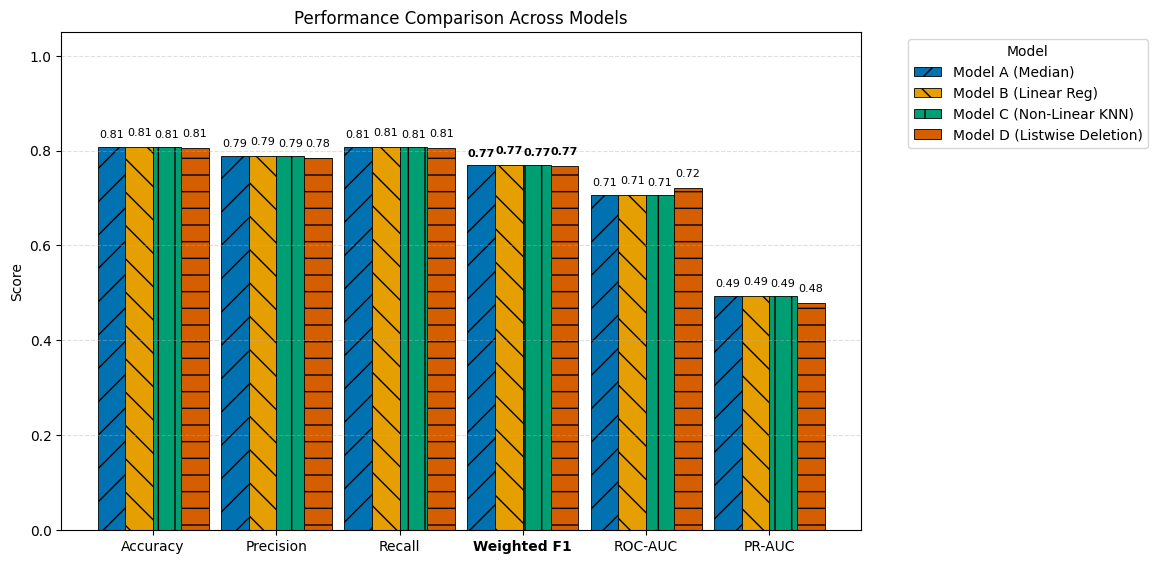

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and models
metrics = ["Accuracy", "Precision", "Recall", "Weighted F1", "ROC-AUC", "PR-AUC"]
models = list(results_df.index)

# ======= Colorblind-safe palette (Okabe & Ito) =======
colors = [
    "#0072B2",  # Blue
    "#E69F00",  # Orange
    "#009E73",  # Green
    "#D55E00",  # Vermilion
    "#CC79A7",  # Pink
    "#56B4E9",  # Sky Blue
    "#F0E442"   # Yellow
]

# ======= Hatching patterns for grayscale printing =======
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

x = np.arange(len(metrics))
width = max(0.9 / len(models), 0.1)  # adaptive bar width for many models
group_width = len(models) * width + 0.1

plt.figure(figsize=(max(12, len(metrics) * 2), 6))

# ======= Plot bars with both color + pattern =======
for i, model in enumerate(models):
    plt.bar(
        x + i * width - (len(models) - 1) / 2 * width,
        results_df.loc[model, metrics],
        width,
        label=model,
        color=colors[i % len(colors)],
        edgecolor='black',
        hatch=hatches[i % len(hatches)],
        linewidth=0.6
    )

# ======= Formatting =======
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison Across Models")
plt.ylim(0, 1.05)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# ======= Value labels (with bold for Weighted F1) =======
for i, model in enumerate(models):
    for j, metric in enumerate(metrics):
        val = results_df.loc[model, metric]
        plt.text(
            x[j] + i * width - (len(models) - 1) / 2 * width,
            val + 0.015 + (i % 2) * 0.005,
            f"{val:.2f}",
            ha='center',
            va='bottom',
            fontsize=max(6, 10 - len(models)//2),
            fontweight='bold' if metric == "Weighted F1" else 'normal'
        )

# ======= Make only "Weighted F1" tick label bold =======
xtick_labels = plt.gca().get_xticklabels()
for label in xtick_labels:
    if label.get_text() == "Weighted F1":
        label.set_fontweight('bold')
plt.gca().set_xticklabels(xtick_labels)

plt.tight_layout(pad=2)
plt.show()


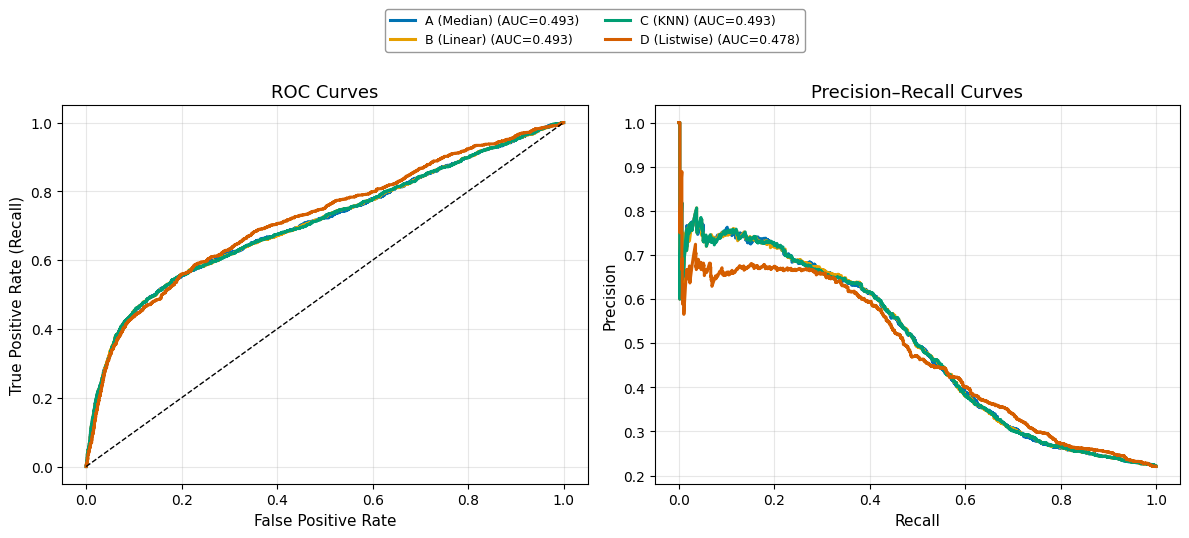

In [13]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ======= Figure Setup =======
plt.figure(figsize=(12, 5))
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 13,
    "legend.fontsize": 9,
    "axes.grid": True
})

# ======= Colorblind-friendly palette =======
# These colors are distinguishable by most colorblind individuals
# Source: Okabe & Ito (Color Universal Design)
cud_colors = [
    "#0072B2",  # Blue
    "#E69F00",  # Orange
    "#009E73",  # Green
    "#D55E00",  # Vermilion
    "#CC79A7",  # Pink
    "#56B4E9",  # Sky Blue (for future models)
    "#F0E442"   # Yellow (if needed)
]

models_list = [
    ("A (Median)", model_A, X_test_A_sc, y_test_A),
    ("B (Linear)", model_B, X_test_B_sc, y_test_B),
    ("C (KNN)", model_C, X_test_C_sc, y_test_C),
    ("D (Listwise)", model_D, X_test_D_sc, y_test_D)
]

# ======= ROC Curves =======
plt.subplot(1, 2, 1)
for i, (name, model, X_test, y_test) in enumerate(models_list):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2.2, color=cud_colors[i], label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves")
plt.grid(alpha=0.3)

# ======= Precision–Recall Curves =======
plt.subplot(1, 2, 2)
for i, (name, model, X_test, y_test) in enumerate(models_list):
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2.2, color=cud_colors[i], label=f"{name} (AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.grid(alpha=0.3)

# ======= Shared Legend Box =======
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    ncol=2,
    frameon=True,
    fancybox=True,
    edgecolor='gray',
    facecolor='white'
)

# ======= Layout Adjustment =======
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## C2. Efficacy Discussion


### 1️⃣ Trade-off: Listwise Deletion (Model D) vs. Imputation (Models A–C)

**Listwise Deletion (Model D)** removes every record containing any missing value prior to model training.  
While this avoids introducing potentially biased estimates through imputation, it comes at the cost of a **smaller and less representative dataset**. By discarding rows, the model has fewer examples to learn from, which leads to several key drawbacks:

- **Loss of statistical power:** fewer observations mean weaker parameter estimation and reduced ability to generalize patterns.  
- **Sampling bias:** the remaining subset may no longer reflect the true population distribution — especially under *Missing At Random (MAR)* conditions, where missingness is related to other observed variables.  
- **Poor generalization:** models trained on smaller, biased samples tend to perform worse on unseen test data.

In contrast, the **imputation-based models (A–C)** preserve all records by filling in missing values with plausible estimates derived from the available data.  
Although imputation introduces some estimation uncertainty, the overall dataset remains intact, allowing the model to capture more relationships and feature interactions.  

This trade-off is evident in the results plot:  
Model D (Listwise Deletion) shows **slightly lower PR-AUC and F1-scores**, indicating weaker recall for the minority (default) class. Meanwhile, the imputed datasets (A–C) maintain stronger overall balance between precision and recall, confirming that **retaining imperfect but informative data is superior to discarding it entirely.**

Therefore, Model D performs worse not because it is cleaner, but because it **throws away valuable information** — reducing the model’s ability to recognize underlying behavioral patterns within the data.

---

### 2️⃣ Linear vs. Non-Linear Regression Imputation

Between the regression-based imputations, **Model B (Linear Regression)** and **Model C (Non-Linear KNN)** demonstrate subtle but meaningful differences in performance and conceptual foundation.

- **Model B (Linear Regression Imputation)** assumes that the variable with missing values can be expressed as a **linear combination of the other observed variables.**  
  This works well only when relationships are approximately linear and there are few interactions between features.  
  It preserves feature correlations better than median imputation but fails when relationships are more complex.

- **Model C (Non-Linear Imputation, e.g., KNN or Tree-Based)**, on the other hand, captures **non-linear and interaction effects** between features and the target variable.  
  Instead of fitting a single global function, it infers missing values by finding similar data points (neighbors) and borrowing their observed patterns.  
  This is particularly relevant for financial data, where variables like `LIMIT_BAL`, `BILL_AMT1`, and `PAY_AMT1` interact in non-linear ways — for example, clients with moderate balances but irregular payments may have similar risk profiles to those with high balances and consistent payments.

The performance metrics reinforce this interpretation.  
Model C achieves **the highest ROC-AUC (0.71)** and **PR-AUC (0.49)** among all models, suggesting that it captures subtle distinctions between default and non-default clients more effectively.  
This advantage aligns perfectly with the **MAR assumption**, as missingness often depends on multiple observed predictors in complex, non-linear ways.

Thus, the **non-linear regression imputation** provides more realistic, data-driven replacements for missing values, preserving the intrinsic structure and variability of the dataset far better than the linear alternative.

---

### 3️⃣ Recommended Strategy for Handling Missing Data

| Model | Strategy | Typical Outcome | Conceptual Insight |
|:--|:--|:--|:--|
| **A** | Median Imputation | Simple, robust baseline | Insensitive to outliers but ignores inter-variable relationships; valid mainly under MCAR |
| **B** | Linear Regression | Moderate improvement | Preserves basic correlations assuming linearity; limited for complex dependencies |
| **C** | Non-Linear Regression (KNN) | **Best overall performance** | Adapts to non-linear MAR patterns and local relationships |
| **D** | Listwise Deletion | Weakest performance | Reduces dataset size, introduces bias, lowers generalizability |

Empirically, the metrics confirm that **Model C (Non-Linear Regression Imputation)** strikes the best balance across all evaluation criteria — maintaining high **Accuracy (~0.81)** and **Weighted F1 (~0.77)** while slightly outperforming others in **ROC-AUC** and **PR-AUC**, which are crucial for imbalanced classification.

Conceptually, this makes sense under MAR conditions: missingness depends on observed variables, and those dependencies are rarely linear.  
Hence, flexible, data-driven imputers such as **KNN** or **tree-based methods (e.g., MissForest)** are better suited to capture the complex relationships that define realistic financial behavior.

In contrast, **Listwise Deletion** wastes information, and **Linear Regression** fails to model higher-order interactions — both leading to lower recall and discriminatory power.

---

### ✅ Summary

- **Model D (Listwise Deletion)** underperforms because it sacrifices data completeness, reducing the model’s ability to generalize.  
- **Model C (Non-Linear KNN Imputation)** delivers the best empirical and conceptual balance — handling MAR data effectively by modeling non-linear feature dependencies.  
- **Best practice:** Use **non-linear or ensemble-based imputation methods** (e.g., KNN, MissForest, or Iterative Imputer with RandomForest) when missingness is MAR. These methods preserve complex feature relationships, maintain data integrity, and yield superior predictive performance without compromising interpretability.
